# Project 1: Sentiment Analysis 

This notebook details a machine learning model that analyzes twitter messages and predicts its sentiment.

In [1]:
import contractions
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from huggingface_hub import hf_hub_download
from gensim.models import KeyedVectors
from nltk.tokenize import TweetTokenizer
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

2025-09-13 15:15:09.647085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757790909.865877    2433 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757790909.932579    2433 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757790910.427681    2433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757790910.427797    2433 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757790910.427800    2433 computation_placer.cc:177] computation placer alr

In [2]:
df = pd.read_csv('Data/sentiment_data.csv')
df.head()

,Unnamed: 0,Comment,Sentiment
0,0,lets forget apple pay required brand new iphon...,1
1,1,nz retailers don’t even contactless credit car...,0
2,2,forever acknowledge channel help lessons ideas...,2
3,3,whenever go place doesn’t take apple pay doesn...,0
4,4,apple pay convenient secure easy use used kore...,2


## Downloading Glove Embeddings

GloVe dictionaries are collections of pretrained word embeddings. By mapping words to dense vector representations, they provide the model with the semantic relationships it needs to make well-rounded predictions. Without contextual embeddings, a model might misclassify the phrase ‘not bad’ as negative. This happens when sentiment is assessed word by word, ignoring how words influence each other’s meaning.

In [3]:
repo_id = "fse/glove-twitter-200"   # repo name on Hugging Face
file1 = "glove-twitter-200.model"
file2 = "glove-twitter-200.model.vectors.npy"
    
# Download both
model_file = hf_hub_download(repo_id=repo_id, filename=file1)
vectors_file = hf_hub_download(repo_id=repo_id, filename=file2)
    
print("Downloaded model:", model_file)
print("Downloaded vectors:", vectors_file)

glove_model = KeyedVectors.load(model_file)

Downloaded model: /home/saniaa/.cache/huggingface/hub/models--fse--glove-twitter-200/snapshots/72f480c107aaa58b9474ddaf45d13db2e34fa166/glove-twitter-200.model
Downloaded vectors: /home/saniaa/.cache/huggingface/hub/models--fse--glove-twitter-200/snapshots/72f480c107aaa58b9474ddaf45d13db2e34fa166/glove-twitter-200.model.vectors.npy


## Data Cleaning:

In [4]:
#checking how much data is left after dropping null values

df = df.drop(columns = 'Unnamed: 0')
print(len(df))

df = df.dropna()
print(len(df))

241145
240928


## Preprocessing:

### Tokenizing:

The model can't classify the text directly because they are still in sentence form. Since every word is mapped to a vector, I have to tokenize each message into it's individual words. The gloVe-model wasn't trained on my data, so some of the words in my dataset may not appear in its vocabulary. However, as long as there aren't that many, dropping them won't effect the sentiment of the text.

In [5]:
twtk = TweetTokenizer()

def make_token(sen):
    sen = contractions.fix(sen)
    return twtk.tokenize(sen)

df['Tokens'] = [make_token(sentence) for sentence in tqdm(df['Comment'])]
df.head()

100%|████████████████████████████| 240928/240928 [00:12<00:00, 19949.05it/s]


,Comment,Sentiment,Tokens
0,lets forget apple pay required brand new iphon...,1,"[let, us, forget, apple, pay, required, brand,..."
1,nz retailers don’t even contactless credit car...,0,"[nz, retailers, do, not, even, contactless, cr..."
2,forever acknowledge channel help lessons ideas...,2,"[forever, acknowledge, channel, help, lessons,..."
3,whenever go place doesn’t take apple pay doesn...,0,"[whenever, go, place, does, not, take, apple, ..."
4,apple pay convenient secure easy use used kore...,2,"[apple, pay, convenient, secure, easy, use, us..."


### Creating Token Vocabulary and Mapping to Vectors:

In [6]:
#making dictionaries so that each word maps to it's vector

def make_token_vocab(sequences):
    token_vocab = set()  
    for seq in tqdm(sequences):
        for token in seq:
            if token in token_vocab:
                continue
            if token not in glove_model:
                continue
            token_vocab.add(token)
    return list(token_vocab)  
   
def make_token_indexes():
    indexes = []
    for index, token in tqdm(enumerate(token_vocab)):
        indexes.append(index + 1)
    return indexes

def make_vector_vocab():
    vector_vocab = []  
    for token in tqdm(token_vocab):
        vector_vocab.append(glove_model[token])
    return vector_vocab

token_vocab = make_token_vocab(df['Tokens'])
token_indexes = make_token_indexes()
vector_vocab = make_vector_vocab()

100%|████████████████████████████| 240928/240928 [00:03<00:00, 67447.68it/s]
62681it [00:00, 3074243.66it/s]
100%|█████████████████████████████| 62681/62681 [00:00<00:00, 750549.33it/s]


### Padding:

A special <PAD> token is added at index 0 with a vector of zeros. This token is used to fill sequences that are shorter than the maximum length, ensuring all input sequences have the same size. Finally, two dictionaries are created: one mapping tokens to indices (token_index_dict) and one mapping tokens to vectors 

In [7]:
padding_token = '<PAD>'
padding_index = 0
padding_vector = np.zeros_like(vector_vocab[0])

token_vocab = [padding_token] + token_vocab
token_indexes = [padding_index] + token_indexes
vector_vocab = [padding_vector] + vector_vocab

token_index_dict = dict(zip(token_vocab, token_indexes))
token_vector_dict = dict(zip(token_vocab, vector_vocab))

In [8]:
#truncating message lengths

max_length = 100

df['Length'] = [len(tokens) for tokens in df['Tokens']]
df = df[df['Length'] < max_length]

### Making Matrices:

I'm converting each token in a message to its corresponding index using the token–index dictionary. Sequences are then padded or truncated to a fixed max_length so that all inputs have the same size. This is becaise neural networks require inputs of the same length for batch processing. Finally, the token vectors are stored in embedding_matrix and the sequences of indices are stored in indices_matrix, ready to feed into the model.

In [9]:
def make_indices(seq):
    sequence = []
    for token in seq:
        if token not in glove_model:
            continue
        else:
            token = token_index_dict[token]
            sequence.append(token)
    return sequence

df['Indices'] = [make_indices(seq) for seq in tqdm(df['Tokens'])] 

def pad_sequence(seq):
    if len(seq) > max_length:
        seq = seq[:max_length]
    elif len(seq) < max_length:
        seq = seq + ([0] * (max_length - len(seq)))
    return seq
    
df['Indices'] = [pad_sequence(seq) for seq in df['Indices']]

embedding_matrix = np.array(vector_vocab)
indices_matrix = np.array(df['Indices'].tolist())
df.head()

100%|███████████████████████████| 240680/240680 [00:02<00:00, 100998.84it/s]


,Comment,Sentiment,Tokens,Length,Indices
0,lets forget apple pay required brand new iphon...,1,"[let, us, forget, apple, pay, required, brand,...",35,"[22606, 45629, 58837, 32360, 11778, 4642, 3764..."
1,nz retailers don’t even contactless credit car...,0,"[nz, retailers, do, not, even, contactless, cr...",20,"[40667, 4392, 51462, 62303, 45125, 17066, 6142..."
2,forever acknowledge channel help lessons ideas...,2,"[forever, acknowledge, channel, help, lessons,...",16,"[19820, 32467, 22247, 6755, 40429, 33347, 1575..."
3,whenever go place doesn’t take apple pay doesn...,0,"[whenever, go, place, does, not, take, apple, ...",58,"[56334, 59395, 26936, 19995, 62303, 25191, 323..."
4,apple pay convenient secure easy use used kore...,2,"[apple, pay, convenient, secure, easy, use, us...",14,"[32360, 11778, 9878, 46005, 46707, 1119, 36668..."


In [10]:
print(embedding_matrix.shape)
print(indices_matrix.shape)

(62682, 200)
(240680, 100)


## Splitting Data:

In [11]:
split_index = int(0.8 * indices_matrix.shape[0])

X_train = indices_matrix[ : split_index]
y_train = df['Sentiment'].values[ : split_index]
y_train = tf.cast(y_train, tf.int32)

X_test = indices_matrix[split_index : ]
y_test = df['Sentiment'].values[split_index : ]
y_test = tf.cast(y_test, tf.int32)

I0000 00:00:1757790965.919893    2433 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1765 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
print(type(X_train), len(X_train))
print(type(y_train), len(y_train))

<class 'numpy.ndarray'> 192544
<class 'tensorflow.python.framework.ops.EagerTensor'> 192544


## Making Model & Training:

I chose an LSTM model because it provides an extra layer of context. Unlike standard neural networks, LSTMs can remember information from previous words in a sequence, which helps capture the sentiment of a sentence more accurately. For example, word order is especially important in the phrase ‘I am happy’. Switching the order to ‘Am I happy?’ changes the sentiment entirely.

In [13]:
def make_model():
    model = keras.Sequential()
    model.add(layers.Embedding(
        input_dim = len(token_vocab),
        output_dim = 200,
        weights = [embedding_matrix],  
        trainable = False,             
        mask_zero = True
    ))
    model.add(layers.LSTM(128, kernel_regularizer=regularizers.l2(0.0001), use_cudnn=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation = 'softmax'))

    return model

model = make_model()

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    12,536,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,536,400 (47.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,536,400 (47.82 MB)

None


In [14]:
model_history = model.fit(
    X_train, y_train,
    batch_size = 128,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test, y_test),
)

Epoch 1/20


I0000 00:00:1757790970.579375    2527 service.cc:152] XLA service 0x79d618268740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757790970.579418    2527 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
I0000 00:00:1757790971.064384    2527 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1757790976.817537    2527 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1505/1505 ━━━━━━━━━━━━━━━━━━━━ 121s 75ms/step - accuracy: 0.6044 - loss: 0.8973 - val_accuracy: 0.6413 - val_loss: 0.8337
Epoch 2/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 129s 85ms/step - accuracy: 0.6622 - loss: 0.8026 - val_accuracy: 0.6663 - val_loss: 0.7866
Epoch 3/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 142s 95ms/step - accuracy: 0.6820 - loss: 0.7646 - val_accuracy: 0.6912 - val_loss: 0.7477
Epoch 4/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 111s 74ms/step - accuracy: 0.6976 - loss: 0.7347 - val_accuracy: 0.7086 - val_loss: 0.7163
Epoch 5/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - accuracy: 0.7116 - loss: 0.7108 - val_accuracy: 0.7197 - val_loss: 0.6938
Epoch 6/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 130s 86ms/step - accuracy: 0.7227 - loss: 0.6904 - val_accuracy: 0.7374 - val_loss: 0.6628
Epoch 7/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 129s 86ms/step - accuracy: 0.7330 - loss: 0.6717 - val_accuracy: 0.7440 - val_loss: 0.6515
Epoch 8/20
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 130s 86ms/step - accuracy: 0.7395 - los

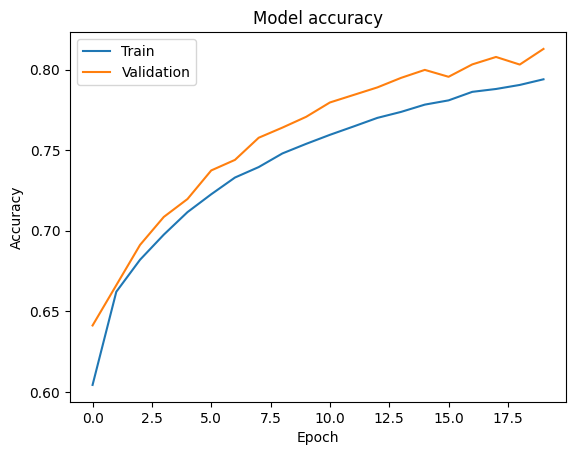

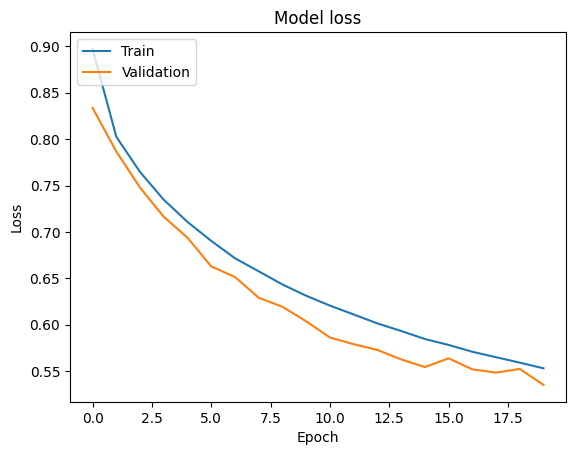

In [15]:
# plotting training accuracy & validation accuracy 

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plotting training loss & validation loss 

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Adjusting Model & Training:

I wanted to see if allowing the model to fine-tune GloVe embeddings would better the accuracy. So, I made a new model where they were trainable. I also reduced the number of epochs (I was impatient)

In [16]:
def make_model_1():
    model = keras.Sequential()
    model.add(layers.Embedding(
        input_dim = len(token_vocab),
        output_dim = 200,
        weights = [embedding_matrix],  
        trainable = True,             
        mask_zero = True
    ))
    model.add(layers.LSTM(128, kernel_regularizer=regularizers.l2(0.0001), use_cudnn=False))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(3, activation = 'softmax'))

    return model

model_1 = make_model_1()

model_1.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

print(model_1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │    12,536,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,536,400 (47.82 MB)

 Trainable params: 12,536,400 (47.82 MB)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
model_history_1 = model_1.fit(
    X_train, y_train,
    batch_size = 128,
    epochs = 10,
    verbose = 1,
    validation_data = (X_test, y_test),
)

Epoch 1/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 161s 104ms/step - accuracy: 0.6299 - loss: 0.8597 - val_accuracy: 0.7121 - val_loss: 0.7221
Epoch 2/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 150s 100ms/step - accuracy: 0.7355 - loss: 0.6814 - val_accuracy: 0.7865 - val_loss: 0.5838
Epoch 3/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 152s 101ms/step - accuracy: 0.7788 - loss: 0.5918 - val_accuracy: 0.8321 - val_loss: 0.4995
Epoch 4/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 155s 103ms/step - accuracy: 0.8039 - loss: 0.5360 - val_accuracy: 0.8495 - val_loss: 0.4608
Epoch 5/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 153s 101ms/step - accuracy: 0.8199 - loss: 0.4983 - val_accuracy: 0.8653 - val_loss: 0.4406
Epoch 6/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 154s 102ms/step - accuracy: 0.8319 - loss: 0.4688 - val_accuracy: 0.8600 - val_loss: 0.4368
Epoch 7/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 156s 103ms/step - accuracy: 0.8422 - loss: 0.4429 - val_accuracy: 0.8635 - val_loss: 0.4289
Epoch 8/10
1505/1505 ━━━━━━━━━━━━━━━━━━━━ 152s 101ms/step - ac

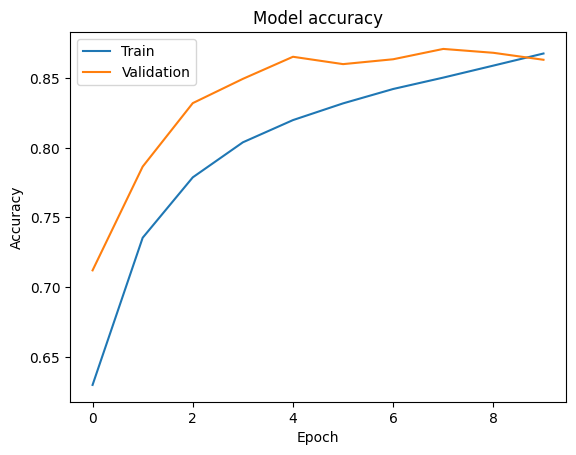

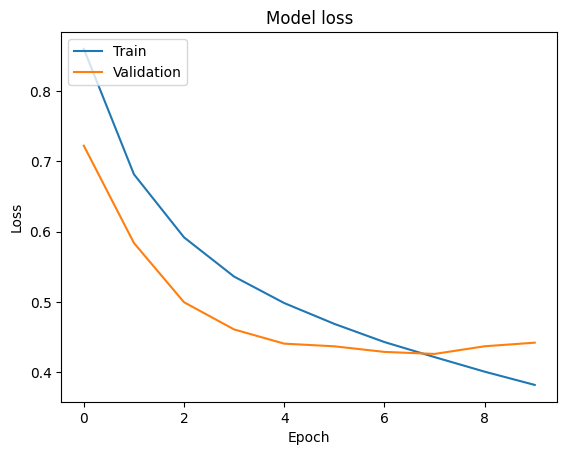

In [18]:
# Plot training & validation accuracy values
plt.plot(model_history_1.history['accuracy'])
plt.plot(model_history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_history_1.history['loss'])
plt.plot(model_history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Ultimately, the model does perform better! It went from an 81% validation accuracy to an 86% validation accuracy. However, there's minor overfitting towards the end of it's training.